In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pandas import read_csv
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

In [2]:
def read_data(file_name):
    a = read_csv('data/' + file_name + '.csv')
    return np.array(a[['x', 'y']].values.tolist()), np.array([1 if c == 'P' else -1 for c in a['class']])

X_chips, y_chips = read_data('chips')
X_geyser, y_geyser = read_data('geyser')

In [3]:
def dist(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def linear(x, y, _):
    return np.dot(x, y)

def polynomial(x, y, d):
    return (np.dot(x, y) + 1) ** d

def gaussian(x, y, sigma):
    return np.exp( - dist(x, y) ** 2 / (2 * sigma ** 2))

In [4]:
def svm(X, y, C, kernel, parameter):
    N = len(X)
    b = 0
    lambdas = np.zeros(N)
    K = np.array([[kernel(X[i], X[j], parameter) for j in range(N)] for i in range(N)])
    
    def f(i):
        return np.sum(y * lambdas * K[i]) + b
    
    def random_j(i):
        j = np.random.randint(0, N)
        while i == j:
            j = np.random.randint(0, N)
        return j
    
    for _ in range(100):
        for i in range(N):
            E_i = f(i) - y[i]
            if y[i] * E_i < -1e-10 and lambdas[i] < C or y[i] * E_i > 1e-10 and lambdas[i] > 0:
                j = random_j(i)
                E_j = f(j) - y[j]
                    
                old_lambda_i = lambdas[i]
                old_lambda_j = lambdas[j]

                L, H = 0., 0.
                if y[i] != y[j]:
                    L = max(0.0, lambdas[j] - lambdas[i])
                    H = min(C, C + lambdas[j] - lambdas[i])
                else: 
                    L = max(0.0, lambdas[i] + lambdas[j] - C)
                    H = min(C, lambdas[i] + lambdas[j])

                if abs(L - H) < 1e-15:
                    continue

                n = 2 * K[i][j] - K[i][i] - K[j][j]
                if n >= 0:
                    continue

                lambdas[j] -= y[j] * (E_i - E_j) / n
                lambdas[j] = min(max(lambdas[j], L), H)
                if abs(lambdas[j] - old_lambda_j) < 1e-10:
                    continue

                lambdas[i] += y[i] * y[j] * (old_lambda_j - lambdas[j])

                b1 = b - E_i - y[i] * (lambdas[i] - old_lambda_i) * K[i][i] - y[j] * (lambdas[j] - old_lambda_j) * K[i][j]
                b2 = b - E_j - y[i] * (lambdas[i] - old_lambda_i) * K[i][j] - y[j] * (lambdas[j] - old_lambda_j) * K[j][j]
                if 0 < lambdas[i] < C:
                    b = b1
                elif 0 < lambdas[j] < C:
                    b = b2
                else:
                    b = (b1 + b2) / 2
        
    return lambdas, b

In [5]:
def predict(x, X_train, y_train, lambdas, b, kernel, parameter):
    k = np.array([kernel(x, x_i, parameter) for x_i in X_train])
    return np.sign(np.sum(y_train * lambdas * k) + b)

In [6]:
def fit(X, y, kernel):
    k = 5
    kf = KFold(n_splits=k, shuffle=True)
    X_train, X_test, y_train, y_test = [], [], [], []
    for train_indices, test_indices in kf.split(X):
        X_train.append(np.array([X[i] for i in train_indices]))
        X_test.append(np.array([X[i] for i in test_indices]))
        y_train.append(np.array([y[i] for i in train_indices]))
        y_test.append(np.array([y[i] for i in test_indices]))
    
    best_parameter, best_C, best_f_score = 0, 0, 0
    
    base = np.arange(1, 11)
    Cs = np.hstack([0.001 * base, 0.01 * base, 0.1 * base, base, 10 * base])
    for C in tqdm(Cs):
        for parameter in range(1, 101):
            y_true, y_predicted = [], []
            for i in range(k):
                lambdas, b = svm(X_train[i], y_train[i], C, kernel, parameter)
                for x, y in zip(X_test[i], y_test[i]):
                    y_true.append(y)
                    y_predicted.append(predict(x, X_train[i], y_train[i], lambdas, b, kernel, parameter))
            f_score = f1_score(y_true, y_predicted, average='micro')
            if f_score > best_f_score:
                best_f_score = f_score
                best_C = C
                best_parameter = parameter
    return best_parameter, best_C

In [7]:
def get_colors(v):
    return ['green' if y == 1 else 'red' for y in v]

def draw_graphics(X, y, kernel):
    parameter, C = fit(X, y, kernel)
    
    print('kernel =', kernel.__name__)
    if kernel.__name__ != 'linear':
        print('parameter =', parameter)
    print('C =', C)
    
    plt.scatter(X[:, 0], X[:, 1], c=get_colors(y), s=20)
    
    
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    points_count = 100
    background_X_x, background_X_y = np.meshgrid(
        np.linspace(xlim[0], xlim[1], points_count),
        np.linspace(ylim[0], ylim[1], points_count))
    
    
    lambdas, b = svm(X, y, C, kernel, parameter)
    background_Y = [predict(np.array([xx, xy]), X, y, lambdas, b, kernel, parameter) 
                    for xx, xy in zip(background_X_x.ravel(), background_X_y.ravel())]
    plt.scatter(background_X_x, background_X_y, c=get_colors(background_Y), s=1, alpha=0.4)


kernel = linear
C = 50.0


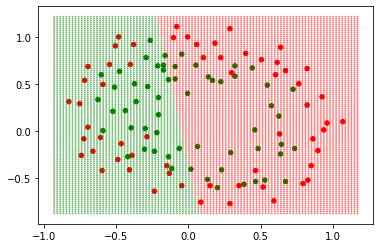

In [8]:
draw_graphics(X_chips, y_chips, linear)


kernel = polynomial
parameter = 4
C = 10.0


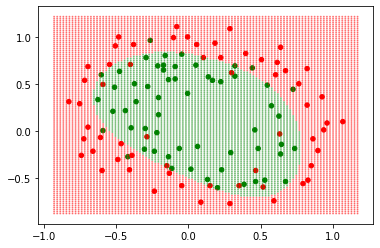

In [9]:
draw_graphics(X_chips, y_chips, polynomial)


kernel = gaussian
parameter = 1
C = 70.0


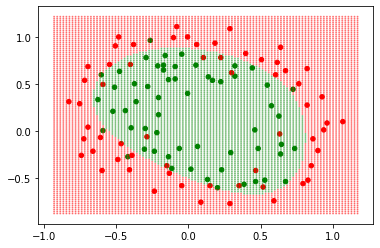

In [10]:
draw_graphics(X_chips, y_chips, gaussian)


kernel = linear
C = 0.5


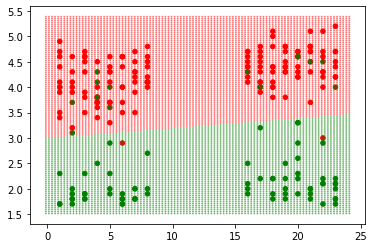

In [11]:
draw_graphics(X_geyser, y_geyser, linear)


kernel = polynomial
parameter = 2
C = 0.006


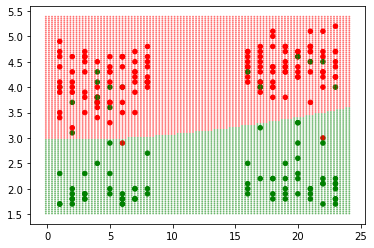

In [12]:
draw_graphics(X_geyser, y_geyser, polynomial)


kernel = gaussian
parameter = 7
C = 9.0


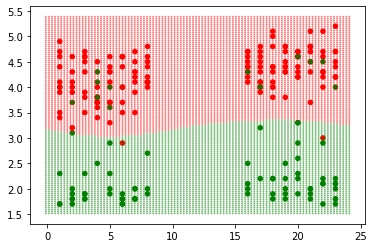

In [13]:
draw_graphics(X_geyser, y_geyser, gaussian)